In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
from scipy.stats import wilcoxon, norm
import matplotlib.patches as mpatches

OUT_DIR = Path("plots")
OUT_DIR.mkdir(exist_ok=True)

survey_answers = 'survey_answers.csv'
generated_guis_path = '../generated_guis'
prompts = ["instruction", "pd_zs", "pd_fs", "ref_instruction"]
metrics = ['descrition', 'components', 'intuitiveness', 'errors','appeal','overall']

app_ids = [name for name in os.listdir(generated_guis_path) if os.path.isdir(os.path.join(generated_guis_path, name))]

In [30]:
df_raw = pd.read_csv(survey_answers, delimiter=',')

df = pd.DataFrame()
df["user"] = df_raw["ip"]
df["age"] = df_raw["age"]
df["exp_test"] = df_raw["exp_test"]
df["exp_dev"] = df_raw["exp_dev"]

answers = [[o.split('_')[3] for o in odg.split(',')] for odg in df_raw["odgovori"]]

frames = []
for combined_answer in df_raw["odgovori"]:
    answers = combined_answer.split(',')
    row_dict = {answer[:-2]: int(answer[-1]) for answer in answers}
    frames.append(pd.DataFrame([row_dict]))

df_answers = pd.concat(frames, ignore_index=True)
df = pd.concat([df, df_answers], axis=1)

id_vars = ['user', 'age', 'exp_test', 'exp_dev']
df_long = df.melt(id_vars=id_vars, var_name='question_code', value_name='answer')
df_long[['app_id', 'prompt', 'criteria']] = df_long['question_code'].str.extract(r'a(\d+)_p(\d+)_c(\d+)')
df_long = df_long.drop(columns=['question_code'])
df_long = df_long[['user', 'age', 'exp_test', 'exp_dev', 'app_id', 'prompt', 'criteria', 'answer']]

df_long['prompt'] = df_long['prompt'].replace({
    '1': 'instruction',
    '2': 'pd_zs',
    '3': 'pd_fs',
    '4': 'ref_instruction'
})

df_long['criteria'] = df_long['criteria'].replace({
    '0': 'descrition',
    '1': 'components',
    '2': 'intuitiveness',
    '3': 'errors',
    '4': 'appeal',
    '5': 'overall'
})

df_wide = df_long.pivot_table(
    index=['user', 'age', 'exp_test', 'exp_dev', 'app_id', 'prompt'],
    columns='criteria',
    values='answer'
).reset_index()

df_wide

criteria,user,age,exp_test,exp_dev,app_id,prompt,appeal,components,descrition,errors,intuitiveness,overall
0,146.212.107.247,23,2,4,12740,instruction,3.0,5.0,5.0,2.0,5.0,3.0
1,146.212.107.247,23,2,4,12740,pd_fs,3.0,3.0,5.0,2.0,4.0,3.0
2,146.212.107.247,23,2,4,12740,pd_zs,4.0,5.0,5.0,3.0,5.0,4.0
3,146.212.107.247,23,2,4,12740,ref_instruction,4.0,4.0,5.0,4.0,5.0,4.0
4,146.212.107.247,23,2,4,22151,instruction,4.0,5.0,5.0,4.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
811,89.143.77.96,26,3,4,69574,ref_instruction,3.0,4.0,3.0,3.0,4.0,3.0
812,89.143.77.96,26,3,4,8640,instruction,2.0,2.0,2.0,2.0,3.0,2.0
813,89.143.77.96,26,3,4,8640,pd_fs,4.0,3.0,3.0,3.0,4.0,4.0
814,89.143.77.96,26,3,4,8640,pd_zs,3.0,2.0,2.0,2.0,2.0,2.0


In [42]:
def highlight_best_latex(df, metric_cols):
    df_formatted = df.copy()
    for col in metric_cols:
        max_val = df[col].max()
        df_formatted[col] = df[col].apply(
            lambda x: f"\\textbf{{\\underline{{{x:.3f}}}}}" if x == max_val else f"{x:.3f}"
        )
    return df_formatted

df_avg = df_wide.groupby('prompt')[metrics].mean().reset_index()
df_fmt = highlight_best_latex(df_avg, metrics)

latex_table = df_fmt.to_latex(
    index=False,
    escape=False,
    caption="Rezultati vprašalnika",
    label="tab:survey_results",
    column_format="lrrrrrr",
)

print(latex_table)

\begin{table}
\caption{Rezultati vprašalnika}
\label{tab:survey_results}
\begin{tabular}{lrrrrrr}
\toprule
prompt & descrition & components & intuitiveness & errors & appeal & overall \\
\midrule
instruction & \textbf{\underline{4.515}} & \textbf{\underline{4.245}} & \textbf{\underline{4.309}} & \textbf{\underline{4.029}} & 3.922 & \textbf{\underline{4.172}} \\
pd_fs & 4.279 & 3.985 & 4.235 & 3.789 & 3.740 & 3.917 \\
pd_zs & 4.225 & 4.172 & 4.221 & 3.868 & \textbf{\underline{3.975}} & 4.054 \\
ref_instruction & 4.260 & 4.034 & 4.176 & 3.765 & 3.725 & 3.956 \\
\bottomrule
\end{tabular}
\end{table}



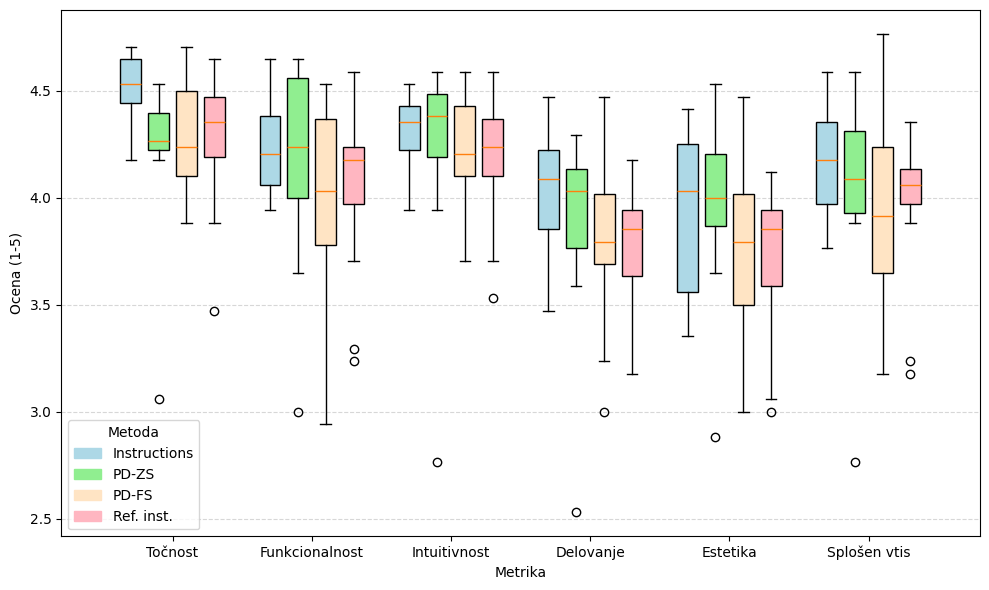

In [62]:
# Pripravi podatke (filtriraj, če imaš več stolpcev)
df_avg = df_wide.groupby(['app_id', 'prompt'])[metrics].mean().reset_index()
df_plot = df_avg[['prompt'] + metrics]

# Ustvari figuro
plt.figure(figsize=(10, 6))

# Za vsako metriko nariši boxplote z offsetom na osi X
positions = []
labels = []
offset = [-0.3, -0.1, 0.1, 0.3]  # zamiki za 4 promte
colors = ['lightblue', 'lightgreen', 'bisque', 'lightpink']
metrics_labels = ['Točnost', 'Funkcionalnost', 'Intuitivnost', 'Delovanje', 'Estetika', 'Splošen vtis']
prompts_labels = ['Instructions', 'PD-ZS', 'PD-FS', 'Ref. inst.']

for i, metric in enumerate(metrics):
    base_x = i + 1
    for j, prompt in enumerate(prompts):
        data = df_plot.loc[df_plot['prompt'] == prompt, metric]
        plt.boxplot(
            data,
            positions=[base_x + offset[j]],
            widths=0.15,
            patch_artist=True,
            boxprops=dict(facecolor=colors[j]),
        )
    positions.append(base_x)
    labels.append(metrics_labels[i])

plt.xticks(positions, labels)
plt.xlabel('Metrika')
plt.ylabel('Ocena (1-5)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

legend_patches = [mpatches.Patch(color=colors[i], label=prompts_labels[i]) for i in range(len(prompts_labels))]
plt.legend(handles=legend_patches, title='Metoda')

plt.tight_layout()
plt.savefig(OUT_DIR / "survey.png")
plt.show()